In [70]:
# sentiment analysis: google vs. apple

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
# ML Libraries
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [188]:
df = pd.read_csv('./tweets.csv', encoding = "ISO-8859-1", names=["tweet", "product", "sentiment"], header=0)

In [189]:
df.head()

,tweet,product,sentiment
0,.@wesley83 I have a 3G iPhone. After 3 hrs twe...,iPhone,Negative emotion
1,@jessedee Know about @fludapp ? Awesome iPad/i...,iPad or iPhone App,Positive emotion
2,@swonderlin Can not wait for #iPad 2 also. The...,iPad,Positive emotion
3,@sxsw I hope this year's festival isn't as cra...,iPad or iPhone App,Negative emotion
4,@sxtxstate great stuff on Fri #SXSW: Marissa M...,Google,Positive emotion


In [190]:
df.info

<bound method DataFrame.info of                                                   tweet             product  \
0     .@wesley83 I have a 3G iPhone. After 3 hrs twe...              iPhone   
1     @jessedee Know about @fludapp ? Awesome iPad/i...  iPad or iPhone App   
2     @swonderlin Can not wait for #iPad 2 also. The...                iPad   
3     @sxsw I hope this year's festival isn't as cra...  iPad or iPhone App   
4     @sxtxstate great stuff on Fri #SXSW: Marissa M...              Google   
...                                                 ...                 ...   
9088                      Ipad everywhere. #SXSW {link}                iPad   
9089  Wave, buzz... RT @mention We interrupt your re...                 NaN   
9090  Google's Zeiger, a physician never reported po...                 NaN   
9091  Some Verizon iPhone customers complained their...                 NaN   
9092  Ï¡Ïàü_ÊÎÒ£Áââ_£â_ÛâRT @...                 NaN   

                   

## Clean data

In [191]:
# make sentiment numeric value

df['positive'] = df['sentiment'].map(lambda x: 1 if x == "Positive emotion" else 0)
df['negative'] = df['sentiment'].map(lambda x: 1 if x == "Negative emotion" else 0)
df['neutral'] = df['sentiment'].map(lambda x: 1 if x == "No emotion toward brand or product" or x == "I can't tell" else 0)

In [192]:
# drop missing products

df.product = df['product'].map(lambda x: np.NaN if x == "NaN" else x)

df.dropna(subset=['product'], inplace=True)

In [193]:
df.shape

(3291, 6)

In [194]:
df_neg = df[df['sentiment'] == -1]
df_pos = df[df['sentiment'] == 1]
df_neutral = df[df['sentiment'] == 0]

In [195]:
df_neg.shape

(0, 6)

In [196]:
df_pos.shape

(0, 6)

In [197]:
df_neutral.shape

(0, 6)

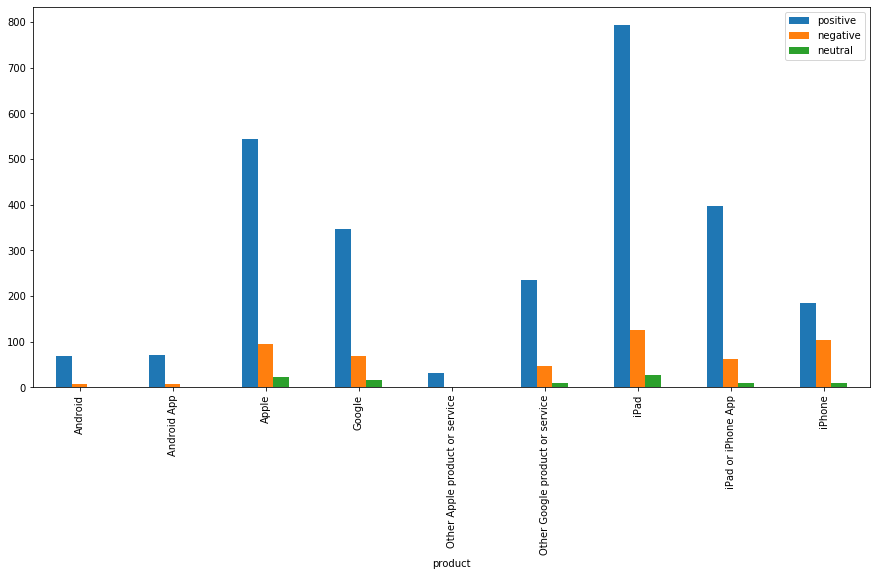

In [203]:
df.groupby(['product']).sum().plot.bar(figsize=(15,7));

In [175]:
def preprocess_tweet_text(tweet):
    tweet.lower()
    # Remove urls
    tweet = re.sub(r"http\S+|www\S+|https\S+", '', tweet, flags=re.MULTILINE)
    # Remove user @ references and '#' from tweet
    tweet = re.sub(r'\@\w+|\#','', tweet)
    # Remove punctuations
    tweet = tweet.translate(str.maketrans('', '', string.punctuation))
    # Remove stopwords
    stop_words = stopwords.words('english') + list(string.punctuation)
    
    tweet_tokens = word_tokenize(tweet)
    filtered_words = [w for w in tweet_tokens if not w in stop_words]
    
    ps = PorterStemmer()
    stemmed_words = [ps.stem(w) for w in filtered_words]
    lemmatizer = WordNetLemmatizer()
    lemma_words = [lemmatizer.lemmatize(w, pos='a') for w in stemmed_words]
    
    return " ".join(filtered_words)

In [122]:
def get_feature_vector(train_fit):
    vector = TfidfVectorizer(sublinear_tf=True)
    vector.fit(train_fit)
    return vector

In [123]:
def int_to_string(sentiment):
    if sentiment == 0:
        return "Negative"
    elif sentiment == 2:
        return "Neutral"
    else:
        return "Positive"

In [124]:
#Preprocess data
df.tweet = df['tweet'].apply(preprocess_tweet_text)
# Split dataset into Train, Test

# Same tf vector will be used for Testing sentiments on unseen trending data
tf_vector = get_feature_vector(np.array(df.iloc[:, 1]).ravel())
X = tf_vector.transform(np.array(df.iloc[:, 1]).ravel())
y = np.array(df.iloc[:, 0]).ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=30)

# Training Naive Bayes model
NB_model = MultinomialNB()
NB_model.fit(X_train, y_train)
y_predict_nb = NB_model.predict(X_test)
print(accuracy_score(y_test, y_predict_nb))

# Training Logistics Regression model
LR_model = LogisticRegression(solver='lbfgs')
LR_model.fit(X_train, y_train)

y_predict_lr = LR_model.predict(X_test)
print(accuracy_score(y_test, y_predict_lr))

0.0015174506828528073


/Users/koh/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


0.0015174506828528073
